# Rejection Sampling

##### Keywords: sampling, rejection sampling, rejection sampling on steroids

## Contents
{:.no_toc}
* 
{: toc}

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## The goal
Recall that we want to produce a list of values whose histogram has a certain shape. That is, if we're given a function that's taller at 3 than at 7 we want proportionally more 3s in our list than 7s.

## Basic Rejection Sampling

The basic idea, come up with by von Neumann is:

If you have a function you are trying to sample from, whose functional form is well known, basically accept the sample by generating a uniform random number at any $x$ and accepting it if the value is below the value of the function at that $x$.

This is illustrated in the diagram below:

![](images/Rejection.png)


### The process

1. Draw $x$ uniformly from $[x_{min},\, x_{max}]$
2. Draw $y$ uniformly from [0,$y_{max}$]. It is vital that y_{max} be above the highest point in the distribution
3. if $y$ < f($x$), accept the sample: put that x value in the list
4. otherwise reject it: do not put that x value in the list
5. repeat

This works becuase proportionally more samples will be accepted in the regions of $x$-space where the function $f$ is higher.

The reason this all works is the frequentist interpretation of probability in each $x$ sliver (and/or the LLN): As we get more samples the accept-to-total ratio in any sliver comes to reflect the probablity mass in that sliver.

### Example
The following code produces samples that follow the distribution $P(x)=e^{-x}$ 
  for $x=[0,10]$ and generates a histogram of the sampled distribution. 

Count 100676 Accepted 10000


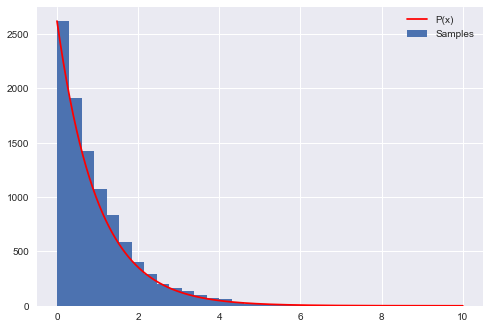

In [6]:

P = lambda x: np.exp(-x)

# domain limits
xmin = 0 # the lower limit of our domain
xmax = 10 # the upper limit of our domain

# range limit (supremum) for y
ymax = 1
#you might have to do an optimization to find this.

N = 10000 # the total of samples we wish to generate
accepted = 0 # the number of accepted samples
samples = np.zeros(N)
count = 0 # the total count of proposals

# generation loop
while (accepted < N):
    
    # pick a uniform number on [xmin, xmax) (e.g. 0...10)
    x = np.random.uniform(xmin, xmax)
    
    # pick a uniform number on [0, ymax)
    y = np.random.uniform(0,ymax)
    
    # Do the accept/reject comparison
    if y < P(x):
        samples[accepted] = x
        accepted += 1
    
    count +=1
    
print("Count",count, "Accepted", accepted)

# get the histogram info
hinfo = np.histogram(samples,30)

# plot the histogram
plt.hist(samples,bins=30, label=u'Samples');

# plot our (normalized) function
xvals=np.linspace(xmin, xmax, 1000)
plt.plot(xvals, hinfo[0][0]*P(xvals), 'r', label=u'P(x)')

# turn on the legend
plt.legend();


Notice that $y_{max}$ was hard-coded here using outside knowledge. Setting $y_{max}$ has an important impact on effecincy. If $y_{max}$ grossly overestimates the true supremum the procedure will still work, but we'll have a very low probability of accepting any sample, lengthning the run time needed to get a fixed number of samples.

## Rejection Sampling with Steroids

The simple rejection sampling method has fundamental problems.  

For our simple example, it's quite easy to determine the supremum.  In practice, while you may know how to quickly (i.e. constant time) evaluate your function everywhere on the domain of interest, finding a bound very close to the  supremum may not be a feasible calculation.  In addition, even if you find a tight bound for the supremum, basic rejection sampling will still be very inefficient as you will reject many samples (especially in low density regions). 

Furthermore, if you support is infinitely large, you are not going to be able to reject from an infinitely long box in finite time!

This is a hard problem to solve and we will need other techniques to address this problem of **low acceptance probability**.


#### Variable bound
However, it is possible to do a more efficient job while still taking advantage of the simplicity of rejection sampling. Instead of a constant bound, we'll let the bound be higher/lower at different points. For technical reasons, we'll phrase this bound function as some multiplier M times a probability density.


The entire process is illustrated in the diagram below:

![](images/rejsteroid.png)

This curvy bound is clearly better than a flat bound across the entire space: we get to bound partciular x values much more tightly.

The distribution we've introduced is called a **proposal density** $g(x)$. This notion of a proposal density is one used in many sampling techniques, in different ways, but its importance will always lie in figuring ways to increase the acceptance rate.

The proposal density will have the following characteristics:

- $g(x)$ is easy to sample from and (calculate the pdf)
- Some $M$ between 1 and $\infty$ exists so that $M \, g(x) > f(x)$ in your entire domain of interest. Basically, this means that the proposal is non-zero everywhere then target is non-zero.
- ideally $g(x)$ will be somewhat close to $f$ so that you'll sample more in high density regions  and much less in low density regions

What's the role of M? Well, since both f (target) and g (proposal) integrate to 1, unless they're exactly the same everywhere, there are some places where g is smaller than f (and others where the opposite is true). We saw above that rejection sampling won't work if the bound is below the target, so we need to scale g up so that it's above f everywhere.

So, it's clear that the M we want to use is just big enough to make g eclipse f everywhere. So the optimal value for M whatever the biggest value of $f/g$ is, across the domain of interest. Of course, the value of M we'd want changes with G.

In fact, we'd like to choose G (if we can) so that M is small. If f and g match perfectly M=1 and we'll accept every sample. And it turns out that if we average across all points, the algorithm's overall acceptance rate is $1/M$. 

You can see that this is the case by finding the proportion of samples from $g(x)$ that are accepted at each $x$ and then averaging over $x$:

$$\int dx g(x) prop(x) =  \int dx g(x) \frac{f(x)}{Mg(x)} = \frac{1}{M}\int dx f(x) = \frac{1}{M}$$

Once you've picked a proposal distribution g, your modified rejection sampling technique is as follows:

1. Draw $x$ from your proposal distribution $g(x)$
2. Draw $y$ uniformly from [0,1]
3. if $y$ < f($x$)/$M g(x)$, accept the sample
4. otherwise reject it
5. repeat


**Example**

The following code produces samples that follow the distribution $P(x)=e^{-x}$ 
  for $x=[0,10]$ and generates a histogram of the sampled distribution. 

Count 24026 Accepted 10000


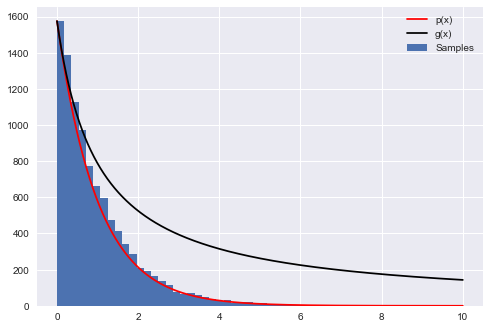

In [3]:

p = lambda x: np.exp(-x)  # our distribution
g = lambda x: 1/(x+1)  # our proposal pdf (we're thus choosing M to be 1)
invCDFg = lambda x: np.log(x +1) # generates our proposal using inverse sampling

# domain limits
xmin = 0 # the lower limit of our domain
xmax = 10 # the upper limit of our domain

# range limits for inverse sampling
umin = invCDFg(xmin)
umax = invCDFg(xmax)

N = 10000 # the total of samples we wish to generate
accepted = 0 # the number of accepted samples
samples = np.zeros(N)
count = 0 # the total count of proposals

# generation loop
while (accepted < N):
    
    # Sample from g using inverse sampling
    u = np.random.uniform(umin, umax)
    xproposal = np.exp(u) - 1
    
    # pick a uniform number on [0, 1)
    y = np.random.uniform(0,1)
    
    # Do the accept/reject comparison
    if y < p(xproposal)/g(xproposal):
        samples[accepted] = xproposal
        accepted += 1
    
    count +=1
    
print("Count", count, "Accepted", accepted)

# get the histogram info
hinfo = np.histogram(samples,50)

# plot the histogram
plt.hist(samples,bins=50, label=u'Samples');

# plot our (normalized) function
xvals=np.linspace(xmin, xmax, 1000)
plt.plot(xvals, hinfo[0][0]*p(xvals), 'r', label=u'p(x)')
plt.plot(xvals, hinfo[0][0]*g(xvals), 'k', label=u'g(x)')



# turn on the legend
plt.legend()


### Why a probability distribution?
In rejection sampling with a non-flat bound, we don't just get to draw whatever bound we want: we must use M times a probability distribution. Further, we must sample candidate Xs from that probability distribution and not any other distribution.

Maybe the easiest way to see why is to go back to the original case of a horizontal bound. Such a bound is really M times a uniform distribution, and our process was to generate Xs uniformly and accept/reject based on a scaled uniform die roll falling above/below the bound.

If we drew X values non-uniformly, e.g. with too many 7s coming up, the same proportion of 7s would be accepted/rejected, but there would be too many 7s in the first place, and so too many 7s in the overall output. We're obligated to draw uniform samples when we use a flat bound.

Similarly, with a proposal g(x) we accept $\frac{f(x)}{Mg(x)}$ percent of the samples at any x. If the probability of drawing a value x is anything other than g(x), we'll still accept $\frac{f(x)}{Mg(x)}$ percent of them, but we won't get cancellation to $\frac{1}{M}f(x)$.